In [1]:
from extern_funcs_cython import interpolate, ln, lstm_state_calculator
from fusion import fusion_quantize_cython, prep_cython
from keyframe_buffer import KeyframeBuffer
from pynq import Overlay, allocate
import numpy as np
import math
import time
import nngen_ctrl as ng

In [2]:
params = np.load("../params_nngen/params.npz")['arr_0']
inputs_npz = np.load("../params_nngen/inputs.npz")
outputs_npz = np.load("../params_nngen/outputs.npz")
predictions_npz = np.load("../params_nngen/predictions.npz")
intrinsics_npz = np.load("../params_nngen/intrinsics.npz")

In [3]:
output_files = ['feature_half',
                'cell_state',
                'hidden_state',
                'depth_org']
cell_state_idx = output_files.index('cell_state')
input_files = ['reference_image',
               'hidden_state',
               'cell_state']
hidden_state_idx = len(output_files) + input_files.index('hidden_state')

In [4]:
chunk_size = 64
def get_end_addr(addr, memory_size):
    return int(math.ceil((addr + memory_size) / chunk_size)) * chunk_size

def shape2size(shape):
    size = 1
    for s in shape:
        size *= s
    return size

In [5]:
axi_datawidth = 128
act_bit = 16
num_align_words = axi_datawidth // act_bit

output_offset = 0
outputs = []
output_aligned_shapes = []
addrs = [output_offset]
for file in output_files:
    output = outputs_npz[file]
    output_aligned_shape = (*output.shape[:-1], int(math.ceil(output.shape[-1] / num_align_words)) * num_align_words)
    outputs.append(output)
    output_aligned_shapes.append(output_aligned_shape)
    addrs.append(get_end_addr(addrs[-1], shape2size(output_aligned_shape) * (act_bit // 8)))

input_offset = addrs[-1]
inputs = []
for file in input_files:
    input = inputs_npz[file]
    lack = (num_align_words - (input.shape[-1] % num_align_words)) % num_align_words
    if lack > 0:
        input = np.append(input, np.zeros(list(input.shape[:-1]) + [lack], dtype=input.dtype), axis=input.ndim-1)
    input = np.reshape(input, [-1]).astype(np.int16)
    inputs.append(input)
    addrs.append(get_end_addr(addrs[-1], input.size * (act_bit // 8)))
cell_state_offset = addrs[-2] # change output cell_state addr to input addr
addrs[cell_state_idx] = cell_state_offset
param_offset = addrs[-1]
print(output_offset, input_offset, param_offset)
print(addrs)

0 208896 319488
[0, 313344, 104448, 110592, 208896, 307200, 313344, 319488]


In [6]:
bitfile = 'design_1.bit'
ipname = 'dvmvs_0'

overlay = Overlay(bitfile)
# overlay.ip_dict
ip = ng.nngen_core(overlay, ipname)

In [7]:
memory_size = 1024 * 1024 * 192
buf = allocate(shape=(memory_size,), dtype=np.uint8)
buf[param_offset:param_offset + params.size] = params.view(np.int8)

In [8]:
ip.set_global_buffer(buf)
ip.write_buffer_address(cell_state_idx, cell_state_offset)
for i in range(7):
    print(ip.read_buffer_address(i))

0
313344
104448
110592
208896
307200
313344


In [9]:
def prepare_input_value(value, lshift):
    ret = value * (1 << lshift)
    ret = np.clip(ret, -1 * 2 ** (16 - 1) - 1, 2 ** (16 - 1))
    return np.round(ret.astype(np.float64)).astype(np.int16)

In [10]:
reference_image_preds = predictions_npz["reference_image"]
feature_halfs = predictions_npz["feature_half"]
measurement_features = predictions_npz["measurement_features"]
hidden_states = predictions_npz["hidden_state"]
cell_states = predictions_npz["cell_state"]

n_measurement_frames = intrinsics_npz["n_measurement_frames"]
reference_images = intrinsics_npz["reference_image"]
reference_poses = intrinsics_npz["reference_pose"]

max_n_measurement_frames = 2
min_depth = 0.25
max_depth = 20.0
inverse_depth_base = 1 / max_depth
inverse_depth_multiplier = 1 / min_depth - 1 / max_depth

test_keyframe_buffer_size = 30
test_keyframe_pose_distance = 0.1
test_optimal_t_measure = 0.15
test_optimal_R_measure = 0.0

calc = lstm_state_calculator(intrinsics_npz, prepare_input_value, 14-1)
org_hidden_state = prepare_input_value(intrinsics_npz["hidden_state"][0].transpose(0, 2, 3, 1), 14-1).reshape(-1)
org_cell_state = prepare_input_value(intrinsics_npz["cell_state"][0].transpose(0, 2, 3, 1), 12).reshape(-1)

reference_pads = np.zeros([1, 64, 96, 5], dtype=np.int16)

In [11]:
half_K = intrinsics_npz["half_K"][0]
inv_half_K = np.linalg.inv(half_K)

def get_warp_grid_for_cost_volume_calculation(width, height):
    x = np.linspace(0, width - 1, num=int(width))
    y = np.linspace(0, height - 1, num=int(height))
    ones = np.ones(shape=(height, width))
    x_grid, y_grid = np.meshgrid(x, y)
    warp_grid = np.stack((x_grid, y_grid, ones), axis=-1)
    warp_grid = warp_grid.astype(np.float32).reshape(-1, 3).T
    return warp_grid
warp_grid = get_warp_grid_for_cost_volume_calculation(int(96 / 2), int(64 / 2))

def round_and_clip(input):
    info = np.iinfo(np.int16)
    return np.clip(np.round(input).astype(np.int64), info.min, info.max).astype(np.int16)

In [12]:
# opcode -> (func, input.addr, input.aligned_shape, output.addr, output.aligned_shape)
externs = {0x79: (None, 0, (1, 32, 48, 32), 175680960, (1, 32, 48, 64)),
           0x104: (ln(12), 176906688, (1, 2, 3, 512), 176925120, (1, 2, 3, 512)),
           0x105: (ln(12), 176931264, (1, 2, 3, 512), cell_state_offset, (1, 2, 3, 512)),
           0x107: (interpolate(4, 6, 0, 'bilinear'), 104448, (1, 2, 3, 512), 176943552, (1, 4, 6, 512)),
           0x113: (interpolate(8, 12, 0, 'bilinear'), 177029568, (1, 4, 6, 256), 177041856, (1, 8, 12, 256)),
           0x115: (interpolate(8, 12, 0, 'bilinear'), 177091008, (1, 4, 6, 8), 177091392, (1, 8, 12, 8)),
           0x120: (interpolate(16, 24, 0, 'bilinear'), 177194304, (1, 8, 12, 128), 177218880, (1, 16, 24, 128)),
           0x122: (interpolate(16, 24, 0, 'bilinear'), 177317184, (1, 8, 12, 8), 177318720, (1, 16, 24, 8)),
           0x127: (interpolate(32, 48, 0, 'bilinear'), 177533760, (1, 16, 24, 64), 177582912, (1, 32, 48, 64)),
           0x129: (interpolate(32, 48, 0, 'bilinear'), 177779520, (1, 16, 24, 8), 177785664, (1, 32, 48, 8)),
           0x134: (interpolate(64, 96, 0, 'bilinear'), 178350912, (1, 32, 48, 8), 178768704, (1, 64, 96, 8)),
           0x135: (interpolate(64, 96, 0, 'bilinear'), 178252608, (1, 32, 48, 32), 178375488, (1, 64, 96, 32))}

In [26]:
sw = []
hw = []
c2s = {0x79: 801, 0x104: 1093, 0x105: 1135, 0x107: 1151, 0x113: 1207, 0x115: 1235, 0x120: 1281, 0x122: 1309, 0x127: 1355, 0x129: 1383, 0x134: 1454, 0x135: 1429}
for s in [0x79, 0x104, 0x105, 0x107, 0x113, 0x115, 0x120, 0x122, 0x127, 0x129, 0x134, 0x135]:
    print(s)
    ip.base_ip.write(52, c2s[s])

    def run_extern(code, warped_image2s=None):
        if code == 0x102:
            return None
            
        func, input_addr, input_aligned_shape, output_addr, output_aligned_shape = externs[code]
        input = buf[input_addr:input_addr + shape2size(input_aligned_shape) * (act_bit // 8)].view(np.int16).reshape(input_aligned_shape)
        
        start_time = time.time()
        if input.shape[-1] == 8:
            input = input[:,:,:,:1]
        if warped_image2s is None:
            output = func(input)
        else:
            output = np.array(fusion_quantize_cython(np.array(input), warped_image2s), dtype=np.int16)
            # output = round_and_clip(np.concatenate([np.sum(input * warped_image2.astype(np.int32), axis=3, keepdims=True) for warped_image2 in warped_image2s], axis=3) / (1 << 16))
            # output = round_and_clip(np.array([np.sum(np.array(input, dtype=np.int32) * warped_image2, axis=3) for warped_image2 in warped_image2s]).transpose(1, 2, 3, 0) / (1 << 16))
        if output.shape != output_aligned_shape:
            output = np.append(output, np.zeros((*output.shape[:-1], 7), dtype=output.dtype), axis=output.ndim-1)
        if code == s:
            sw.append(time.time() - start_time) 
            
        output = output.astype(np.int16).reshape(-1)
        buf[output_addr:output_addr + shape2size(output_aligned_shape) * (act_bit // 8)] = output.view(np.uint8)

        # print(code, time.time() - start_time)

        if code == 0x79: return input

    keyframe_buffer = KeyframeBuffer(buffer_size=test_keyframe_buffer_size,
                                    keyframe_pose_distance=test_keyframe_pose_distance,
                                    optimal_t_score=test_optimal_t_measure,
                                    optimal_R_score=test_optimal_R_measure,
                                    store_return_indices=False)
    previous = False
    hidden_state = None
    previous_depth = None
    previous_pose = None

    start_time_total = time.time()

    idx = 0
    depths = []
    for n in range(len(reference_images)):
        start_time = time.time()
        response = keyframe_buffer.try_new_keyframe(reference_poses[n][0])

        # print("evaluating %05d.png (response: %d) ..." % (n + 3, response))
        if response == 2 or response == 4 or response == 5:
            continue
        elif response == 3:
            previous = False
            hidden_state = None
            previous_depth = None
            previous_pose = None
            continue

        reference_image_value = prepare_input_value(reference_images[n].transpose(0, 2, 3, 1), 12)
        reference_image_value = np.append(reference_image_value, reference_pads, axis=3).reshape(-1)
        addr = addrs[len(output_files)]
        buf[addr:addr + reference_image_value.size * (act_bit // 8)] = reference_image_value.view(np.uint8)
        # print("prep", time.time() - start_time)
        
        ip.run()

        if response == 0:
            for i in range(len(externs)):
                code = ip.wait_extern()
                ip.resume_extern()
                if i == 0:
                    _, input_addr, input_aligned_shape, _, _ = externs[code]
                    feature_half_value = buf[input_addr:input_addr + shape2size(input_aligned_shape) * (act_bit // 8)].view(np.int16).reshape(input_aligned_shape)
                    keyframe_buffer.add_new_keyframe(reference_poses[n][0], feature_half_value.copy())
            ip.wait()
            print(time.time() - start_time)
            continue

        # start_time_1 = time.time()
        ### prepare fusion ###
        measurement_poses_value = []
        measurement_features_value = []
        frame_number_value = idx
        measurement_frames = keyframe_buffer.get_best_measurement_frames(reference_poses[n][0], max_n_measurement_frames)
        for measurement_frame in measurement_frames:
            measurement_poses_value.append(measurement_frame[0])
            measurement_features_value.append(measurement_frame[1])
        # print("kfb_get", time.time() - start_time_1)

        # start_time_1 = time.time()
        inv_pose2s = np.linalg.inv(np.array(measurement_poses_value))
        warped_image2s = np.array(prep_cython(len(measurement_frames), np.array(measurement_features_value), half_K, inv_half_K, reference_poses[n][0], inv_pose2s, warp_grid), dtype=np.int16)
        # print("fusion.prep", time.time() - start_time_1)

        # timing cannot meat when HW is fast, so add extern before lstm should be better
        # start_time_1 = time.time()
        if previous:
            ### prepare previous_depth and hidden_state ###
            addr = addrs[3]
            output_aligned_shape = output_aligned_shapes[3]
            depth_org = buf[addr:addr + shape2size(output_aligned_shape) * (act_bit // 8)].view(np.int16).reshape(output_aligned_shape)
            depth_org = depth_org[:,:,:,:1]
            depth_org = (depth_org.transpose(0, 3, 1, 2) / (1 << 14)).astype(np.float32)
            inverse_depth_full = inverse_depth_multiplier * depth_org + inverse_depth_base
            previous_depth = 1.0 / inverse_depth_full
            # print("dep", time.time() - start_time_1)

            # start_time_1 = time.time()
            hidden_state_value = calc(hidden_state, previous_depth, previous_pose, reference_poses[n]).reshape(-1)
            addr = addrs[hidden_state_idx]
            buf[addr:addr + hidden_state_value.size * (act_bit // 8)] = hidden_state_value.view(np.uint8)
        else:
            ### prepare hidden_state and cell_state ###
            addr = addrs[hidden_state_idx+1]
            buf[addr:addr + org_cell_state.size * (act_bit // 8)] = org_cell_state.view(np.uint8)
            addr = addrs[hidden_state_idx]
            buf[addr:addr + org_hidden_state.size * (act_bit // 8)] = org_hidden_state.view(np.uint8)
        # print("lstm", time.time() - start_time_1)

        for i in range(len(externs)):
            code = ip.wait_extern()
            # print("e", time.time() - start_time)
            if i == 0:
                feature_half_value = run_extern(code, warped_image2s)
                ip.resume_extern()

                # start_time_1 = time.time()
                keyframe_buffer.add_new_keyframe(reference_poses[n][0], feature_half_value.copy())
                # print("kfb_add", time.time() - start_time_1)
            else:
                run_extern(code)
                ip.resume_extern()
            # print("s", time.time() - start_time)

        # start_time_1 = time.time()
        ### prepare hidden_state and cell_state ###
        addr = addrs[2]
        output_aligned_shape = output_aligned_shapes[2]
        hidden_state = buf[addr:addr + shape2size(output_aligned_shape) * (act_bit // 8)].view(np.int16).reshape(output_aligned_shape)

        previous_pose = reference_poses[n]
        # print("post", time.time() - start_time_1)

        ip.wait()
        hw.append(ip.base_ip.read(48) / 100000000)
        print(time.time() - start_time)

        if previous: depths.append(previous_depth)
        previous = True
        idx += 1


    # print(time.time() - start_time_total)

    addr = addrs[3]
    output_aligned_shape = output_aligned_shapes[3]
    depth_org = buf[addr:addr + shape2size(output_aligned_shape) * (act_bit // 8)].view(np.int16).reshape(output_aligned_shape)
    depth_org = depth_org[:,:,:,:1]
    depth_org = (depth_org.transpose(0, 3, 1, 2) / (1 << 14)).astype(np.float32)
    inverse_depth_full = inverse_depth_multiplier * depth_org + inverse_depth_base
    previous_depth = 1.0 / inverse_depth_full
    depths.append(previous_depth)


121
0.4206969738006592
0.5770554542541504
0.4654529094696045
0.45978498458862305
0.46330904960632324
0.4639883041381836
0.4693777561187744
0.4589402675628662
0.4634530544281006
0.4646897315979004
0.46304750442504883
0.46677255630493164
260
0.4194786548614502
0.4624812602996826
0.46444034576416016
0.46519899368286133
0.46241164207458496
0.460665225982666
0.4652678966522217
0.4660520553588867
0.46234726905822754
0.4618196487426758
0.4670126438140869
0.6881697177886963
261
0.4194793701171875
0.46305155754089355
0.4688596725463867
0.4675424098968506
0.46134376525878906
0.4610438346862793
0.45889830589294434
0.46312594413757324
0.4651947021484375
0.46691322326660156
0.4735255241394043
0.4606912136077881
263
0.4199826717376709
0.4636054039001465
0.46457576751708984
0.7438929080963135
0.47002482414245605
0.6646716594696045
0.468686580657959
0.4695150852203369
0.4608585834503174
0.46125340461730957
0.4610788822174072
0.46170854568481445
275
0.41962313652038574
0.46072816848754883
0.46084451675

In [27]:
sw = np.array(sw).reshape(-1, 11)
hw = np.array(hw).reshape(-1, 11)
assert sw.shape == hw.shape
print(sw.shape)

(12, 11)


In [28]:
in_size = np.array([49152, 3072, 3072, 3072, 6144, 192, 12288, 768, 24576, 3072, 12288, 49152])
out_size = np.array([98304, 3072, 3072, 12288, 24576, 768, 49152, 3072, 98304, 12288, 49152, 196608])
io_size = in_size + out_size

In [34]:
# np.savez_compressed('overheads4', hw=hw, sw=sw)

In [29]:
data = np.median(hw - sw, axis=1)
print(data)

[0.00084849 0.00074146 0.00056897 0.00044164 0.00050187 0.0003712
 0.00087813 0.00038459 0.00201026 0.00042204 0.00049413 0.0047882 ]


In [30]:
np.corrcoef(data, (in_size + out_size))[0,1]

0.8786541794821223

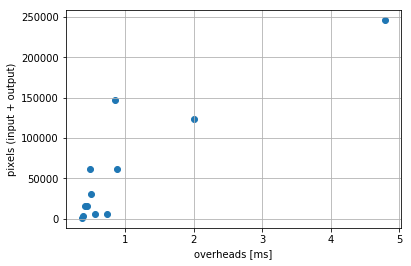

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.scatter(data * 1000, io_size)
# plt.xlim(0, 0.007 * 1000)
plt.xlabel('overheads [ms]')
plt.ylabel('pixels (input + output)')
plt.grid()
plt.show()

In [22]:
predictions = predictions_npz["prediction"]
print(len(predictions), len(depths))
for prediction, depth in zip(predictions, depths):
    print(np.corrcoef(prediction.reshape(-1), depth.reshape(-1))[0, 1])

11 11
0.9981648390543427
0.9992443523984911
0.9974589782005606
0.9984591642086847
0.9992527954355334
0.9986021878380238
0.9969824587282724
0.9988970198837177
0.9997805005553531
0.9998966528702832
0.9991100371905802


In [16]:
start_time_total = time.time()
ip.run()
start_time = time.time()
for i in range(len(externs)):
    code = ip.wait_extern()
    print(time.time() - start_time)
    ip.resume_extern()
    start_time = time.time()
ip.wait()
print(time.time() - start_time)
print(time.time() - start_time_total)

0.2282257080078125
0.07089972496032715
0.00016379356384277344
3.910064697265625e-05
0.010536432266235352
0.004091024398803711
0.006621837615966797
0.004142045974731445
0.007704734802246094
0.00826716423034668
0.01750636100769043
0.0037245750427246094
0.05546164512634277
0.42031359672546387
